In [30]:
import numpy     as  np
import f_VQE     as vqe
import f_shadow  as sh
import f_fermi   as fm
import f_molchem as cm
import os
import matplotlib.pyplot as plt

In [2]:
from openfermion.ops.operators import FermionOperator
from openfermion.transforms import get_fermion_operator
from openfermion.chem       import MolecularData
from openfermion.linalg     import get_ground_state, get_sparse_operator
from openfermionpyscf       import run_pyscf

In [3]:
np.set_printoptions(precision=6,suppress=True)
np.set_printoptions(linewidth=np.inf)

In [4]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 20
bond_length_interval = 3.5 / n_points

# Set calculation parameters.
run_scf  = 1
run_mp2  = 1
run_cisd = 0
run_ccsd = 0
run_fci  = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
fermion_energies = []
bond_lengths = []

In [34]:
# RECONSTRUCTION

vec_scale = [20]
vec_meas  = [-1]
vec_unit  = [200]

In [35]:
#we assume Li-H molecule
ll=4
L0 = range(ll)

Op2, Op4, Op4_com, Base_FOCK  	= fm.Fermi_CC_full(ll)

####### hamiltonian check
def Op2_OF(i,j,ll):
    OP = FermionOperator(str(i)+'^ '+str(j),   1.)
    OP = get_sparse_operator( OP, n_qubits=ll ).todense()
    return OP

def Op4_OF(i,j,k,l,ll):
    OP = FermionOperator(str(i)+'^ '+str(j)+'^ '+str(k)+' '+str(l),   1.)
    OP = get_sparse_operator( OP, n_qubits=ll ).todense()
    return OP

h2  = np.array([[   np.sum(np.abs(Op2[i,j]-Op2_OF(i,j,ll))) for i in L0] for j in L0])
h4  = np.array([[[[ np.sum(np.abs(Op4[i,j,k,l]-Op4_OF(i,j,k,l,ll))) for i in L0] for j in L0] for k in L0] for l in L0])

if np.sum(np.abs(h2))>10**-6:
    print('wrong OPerators')
    quit()

if np.sum(np.abs(h4))>10**-6:
    print('wrong OPerators')
    quit()

In [42]:
data = []

for point in range(0, n_points):
    bond_length = bond_length_interval * float(point) + 0.5
    bond_lengths += [bond_length]
    geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))

    # Run pyscf.
    molecule = run_pyscf(molecule,
                         run_scf=run_scf,
                         run_mp2=run_mp2,
                         run_cisd=run_cisd,
                         run_ccsd=run_ccsd,
                         run_fci=run_fci)
    active_space_start = 1
    active_space_stop  = 3


    # Get the Hamiltonian in the active space.
    molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(active_space_start),
        active_indices=range(active_space_start, active_space_stop))

    fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
    fermion_hamiltonian.compress()
    sparse_hamiltonian  = get_sparse_operator(fermion_hamiltonian)
    energy, state       = get_ground_state(sparse_hamiltonian)
    
###### hamiltonian creation and check
    E0, H2, H4  = cm.ham_coef(molecular_hamiltonian)
        
##### GS energy, 1st state, kinetic, potential, psi, ham 
    E_0s,  E_1s,  Eex_0,  Eex_2,  Eex_4,  psi,  HAM = cm.chem_HAM(E0, H2,  H4,  Op2, Op4_com)
    psih        = np.conjugate(psi)

    cor_2       = np.einsum( 'x,ijxy  ,y->ij',  psih, Op2,     psi, optimize=True)
    nn          = np.trace(cor_2)

    cor_4       = np.einsum( 'x,ijklxy,y->ijkl',psih, Op4_com, psi, optimize=True)
    cor_4_TT    = np.einsum( 'x,ijklxy,y->ijkl',psih, Op4,     psi, optimize=True)


    # CHECKS

    if np.abs(energy-E_0s)>10**-6:
        print('wrong Hamiltonian')
        quit()

    if np.abs(E0-Eex_0)>10**-6:
        print('wrong Hamiltonian')
        quit()

    if np.abs(energy-(Eex_0+Eex_2+Eex_4))>10**-6:
        print(energy, Eex_0+Eex_2+Eex_4,'wrong Hamiltonian')
        quit()

    a = np.sum(np.array([[ cor_4 [i,i,j,j] - cor_2[i,i]*cor_2[j,j] for i in L0] for j in L0] ))
    if np.abs(a)>10**-6:
        print(a, 'no part cons')
        quit()

    # RECONSTRUCTION

    for scale in vec_scale:

        for n_M in vec_meas:
            
            NU  = np.max(vec_unit) 
            ene = sh.shad_en(cor_2, cor_4, ll*scale, NU, n_M, H2, H4)                    
            
            for n_U in vec_unit:

                EE = ene[:n_U].reshape(n_U,2).T
                EE2 = EE[0]
                EE4 = EE[1]

                MME_2 = np.mean(EE2)
                SSE_2 = np.std (EE2)

                MME_4 = np.mean(EE4)
                SSE_4 = np.std (EE4)

                E_tot = E0+MME_2+MME_4
                DE_tot = np.std(EE2+EE4)

                print(round(bond_length, 4), n_M, n_U, Eex_0)
                
                data.append([bond_length, scale, n_M, n_U, E_0s, E_tot, DE_tot])

data = np.array(data)                

0.5 -1 200 -6.060464975653382
0.675 -1 200 -6.365836968791638
0.85 -1 200 -6.521578482002524
1.025 -1 200 -6.62208364657944
1.2 -1 200 -6.69475000668769
1.375 -1 200 -6.750015308001572
1.55 -1 200 -6.793329395247991
1.725 -1 200 -6.828050963781402
1.9 -1 200 -6.856427393656567
2.075 -1 200 -6.880018315074107
2.25 -1 200 -6.899928000789025
2.425 -1 200 -6.916953040728903
2.6 -1 200 -6.931678882233631
2.775 -1 200 -6.944543562500631
2.95 -1 200 -6.9558804687533184
3.125 -1 200 -6.965947478772067
3.3 -1 200 -6.974947100074865
3.475 -1 200 -6.983040606499967
3.65 -1 200 -6.990358109923637
3.825 -1 200 -6.997005825759197


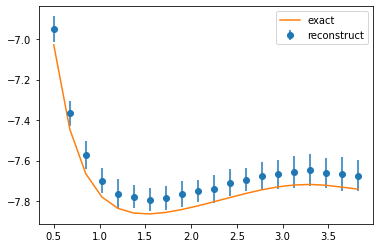

In [43]:
# We plot the first line of the reconstructed one body density matrix

x  = data[:,0].real
y  = data[:,5].real
dy = data[:,6].real

real_y = data[:,4].real

plt.errorbar(x, y, yerr=dy, marker='o', linestyle='None', label='reconstruct');
plt.plot(x, real_y, label='exact')

#plt.xlabel("j")
#plt.ylabel("C(0,j)")

plt.legend()